## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [13]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
task = 'BlockDrawerRedGrab'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-02-18 13:57:26.640 | INFO     |          Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/PickRedBlock/demos/metadata.json
2025-02-18 13:57:26.647 | INFO     |          Extracted gt object labels [0, 1, 2, 3, 4, 5, 6, 255]
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
        },
       

In [35]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [36]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([137, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('gripper',),
                batch_size=torch.Size([137]),
                device=None,
                is_shared=False),
            gripper: SingleCamObservation(
                depth=Tensor(shape=torch.Size([137, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([137, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([137, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([137, 3, 256, 256]), device=cpu, dtype=torch.flo

In [ ]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=1,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=0,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=3,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [38]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-02-18 13:57:59.410 | INFO     |        Fitting AutoTPGMM
2025-02-18 13:57:59.410 | INFO     |        Segmenting trajectories


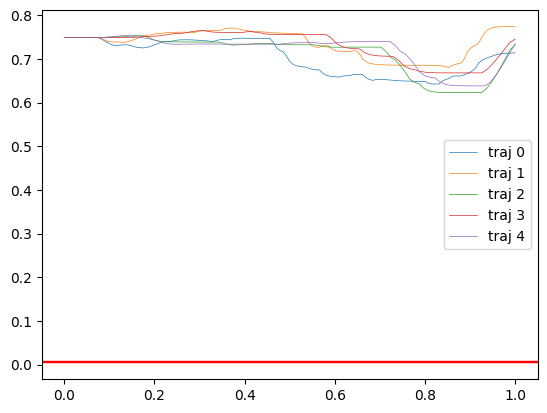

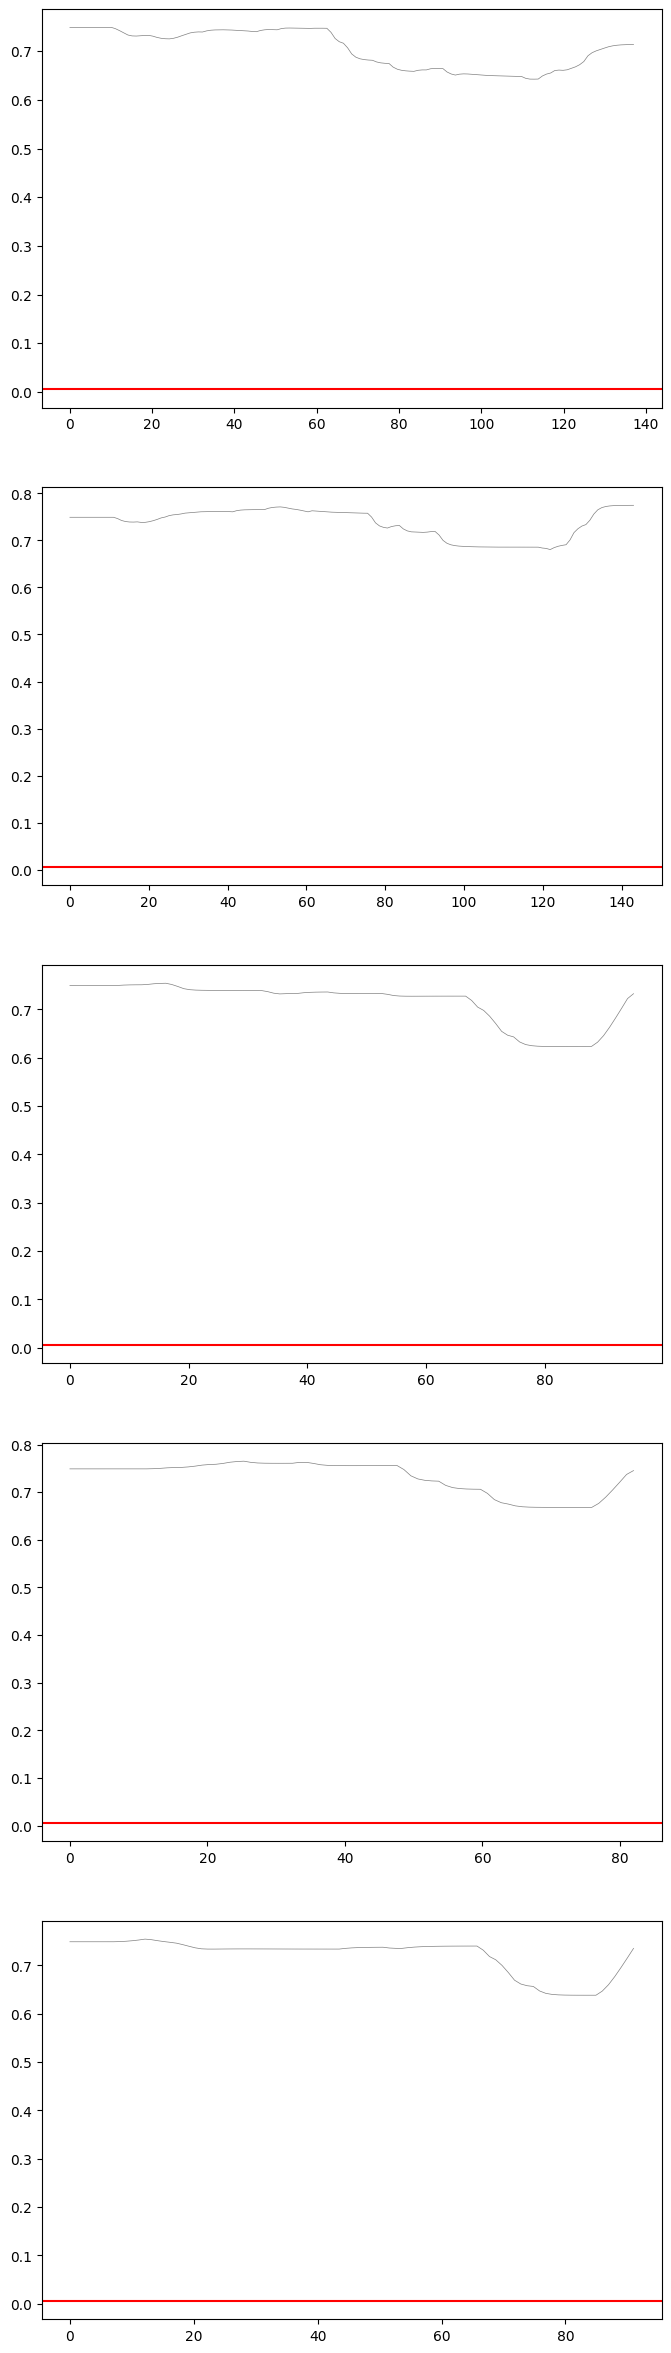

2025-02-18 13:58:00.445 | INFO     |        Creating segement of demos.
2025-02-18 13:58:00.447 | INFO     |        ... created 1 segments
2025-02-18 13:58:00.448 | INFO     |          Fitting candidate frame 1/1
2025-02-18 13:58:00.448 | INFO     |          Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-02-18 13:58:00.495 | INFO     |        Creating partial frame view of demos.
2025-02-18 13:58:00.500 | INFO     |        Segmented trajs into 1 segments
2025-02-18 13:58:00.505 | INFO     |        Frame score (abs):
           ee_init
Segment 0     -1.0
2025-02-18 13:58:00.507 | INFO     |        Frame score (rel):
           ee_init
Segment 0      1.0


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[1.73e+005, 1.73e+005, 1.47e+005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.11e+004, 1.63e+004, 2.28e+004, ..., 6.14e-112, 3.53e-113,
          7.38e-115],
         [6.42e-002, 1.95e-001, 5.55e-001, ..., 1.72e-085, 1.04e-087,
          2.29e-090],
         ...,
         [1.40e-084, 1.34e-082, 1.21e-080, ..., 2.63e-003, 1.15e-004,
          2.37e-006],
         [1.23e-167, 1.73e-164, 2.27e-161, ..., 2.14e+002, 1.02e+002,
          3.71e+001],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.30e+003, 3.40e+003,
          4.45e+003]]),),
 (-7.536679721261555,))

In [39]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-02-18 13:58:33.751 | INFO     |        Did not specify time_based, deciding automatically.


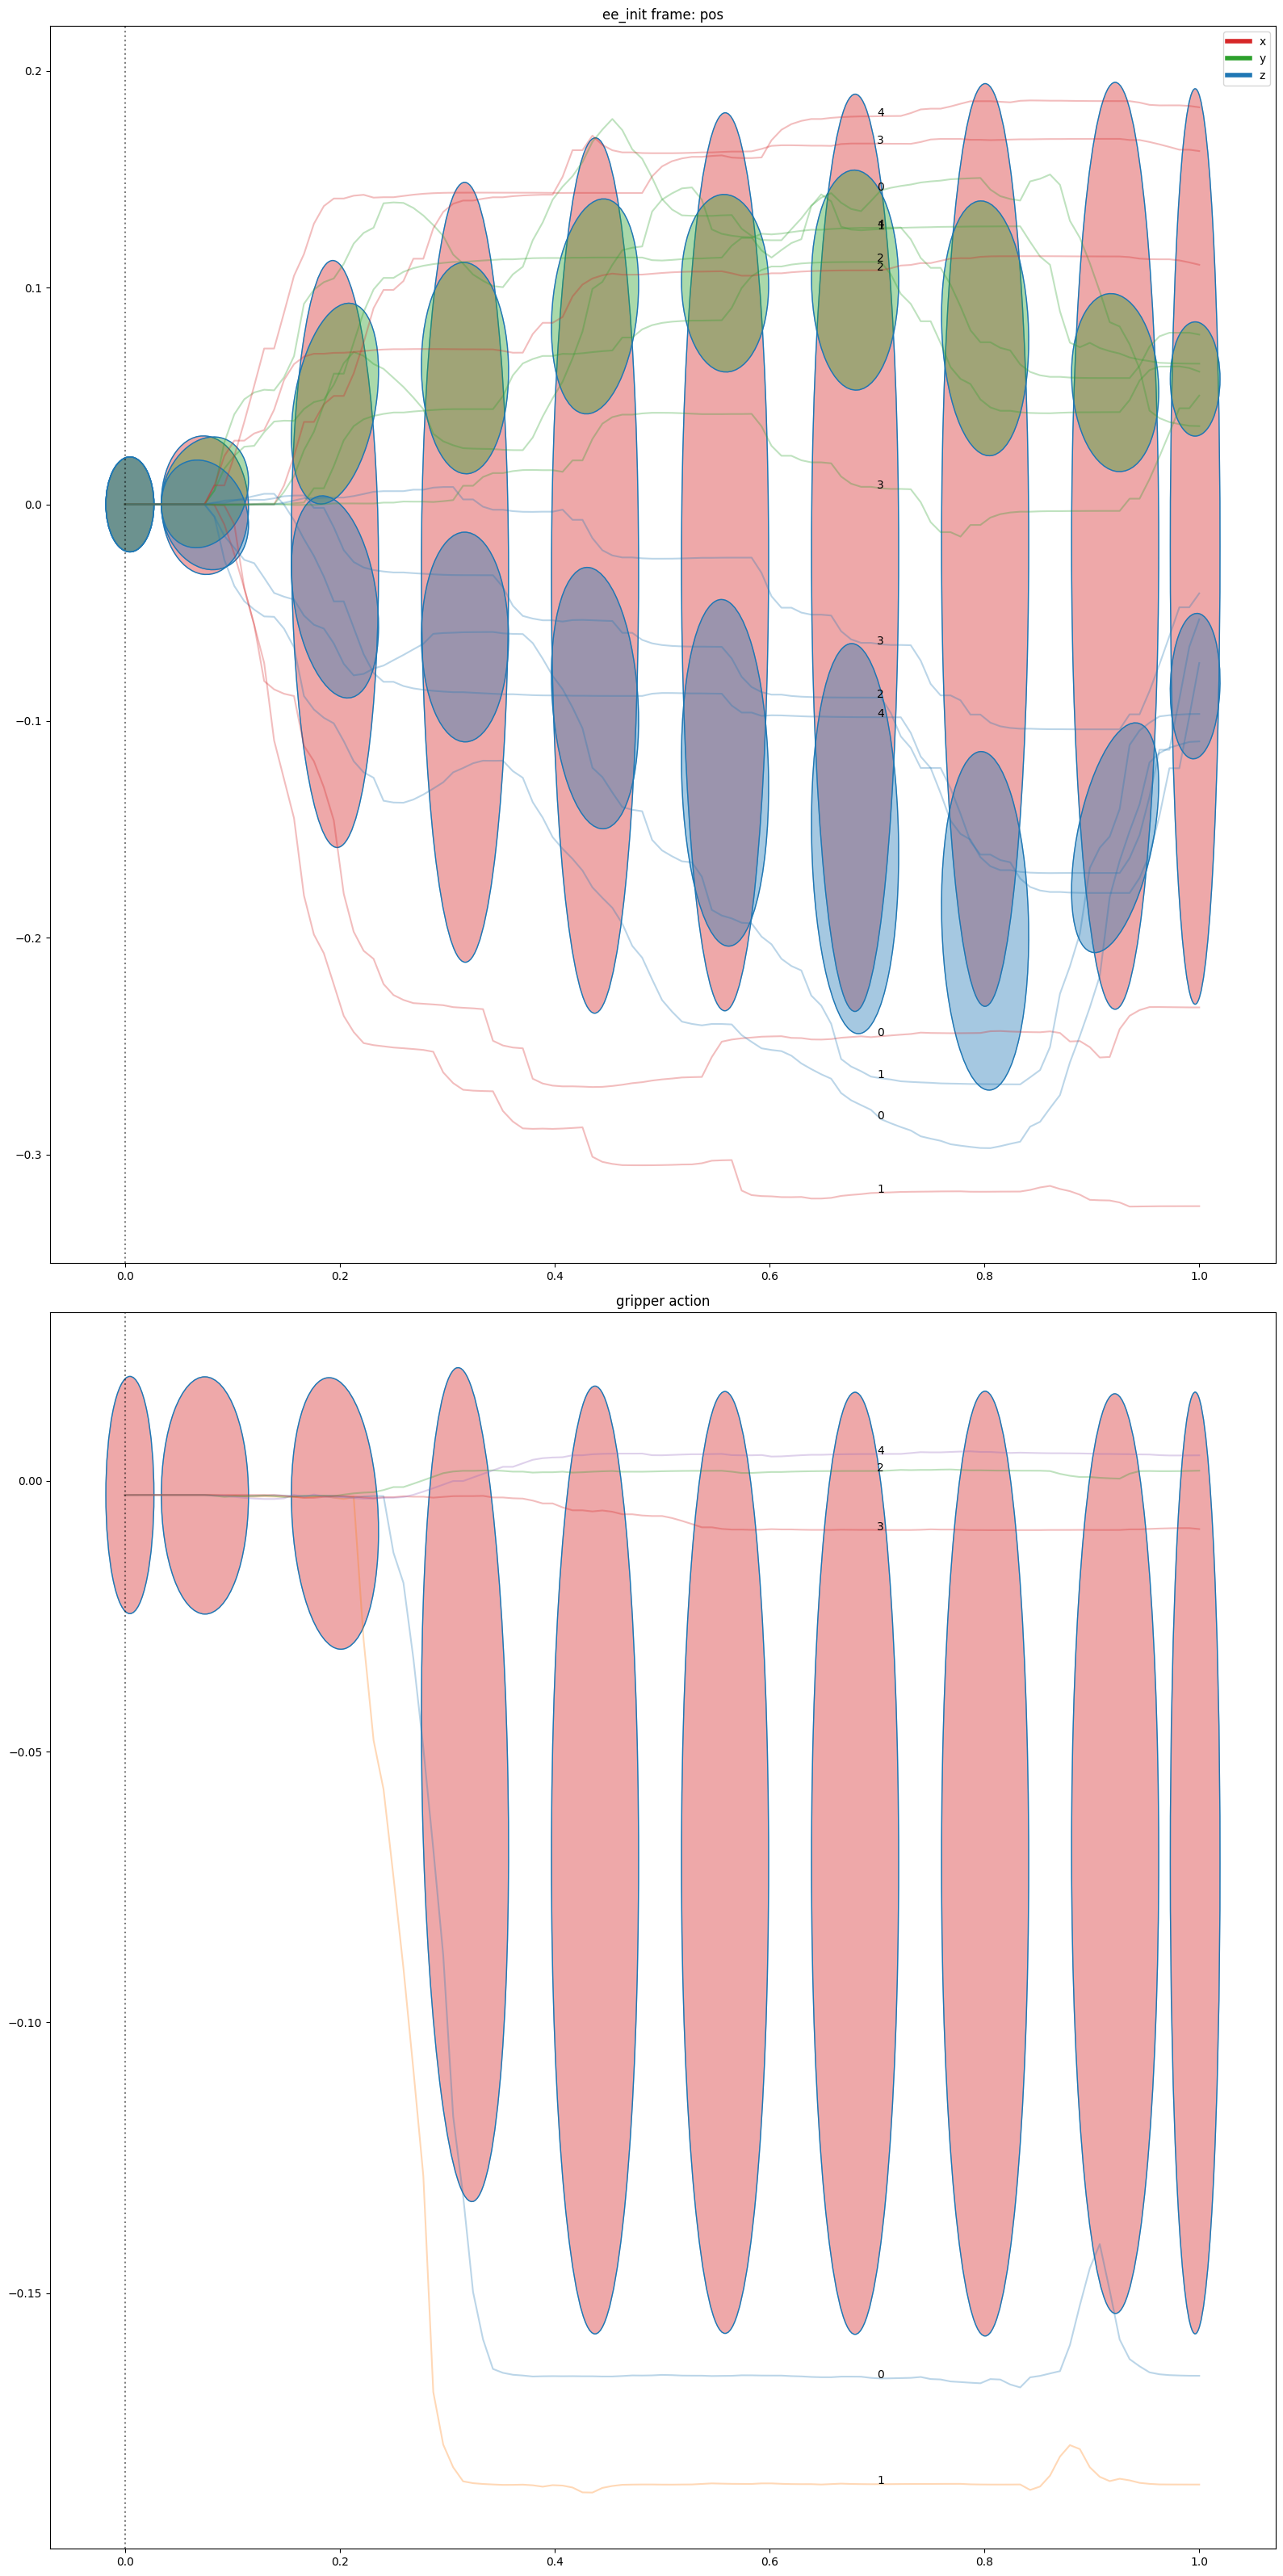

In [40]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [41]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-02-18 13:58:55.143 | INFO     |        Fitting AutoTPGMM


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[9.40e-001, 9.14e-001, 8.66e-001, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [6.00e-002, 8.59e-002, 1.34e-001, ..., 4.05e-115, 1.01e-116,
          1.65e-118],
         [3.48e-007, 1.03e-006, 3.28e-006, ..., 1.13e-088, 2.97e-091,
          5.12e-094],
         ...,
         [7.58e-090, 7.06e-088, 7.15e-086, ..., 1.74e-006, 3.28e-008,
          5.30e-010],
         [6.64e-173, 9.10e-170, 1.34e-166, ..., 1.41e-001, 2.93e-002,
          8.28e-003],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 8.59e-001, 9.71e-001,
          9.92e-001]]),),
 (821.4980896175095,))

2025-02-18 13:59:02.645 | INFO     |        Did not specify time_based, deciding automatically.


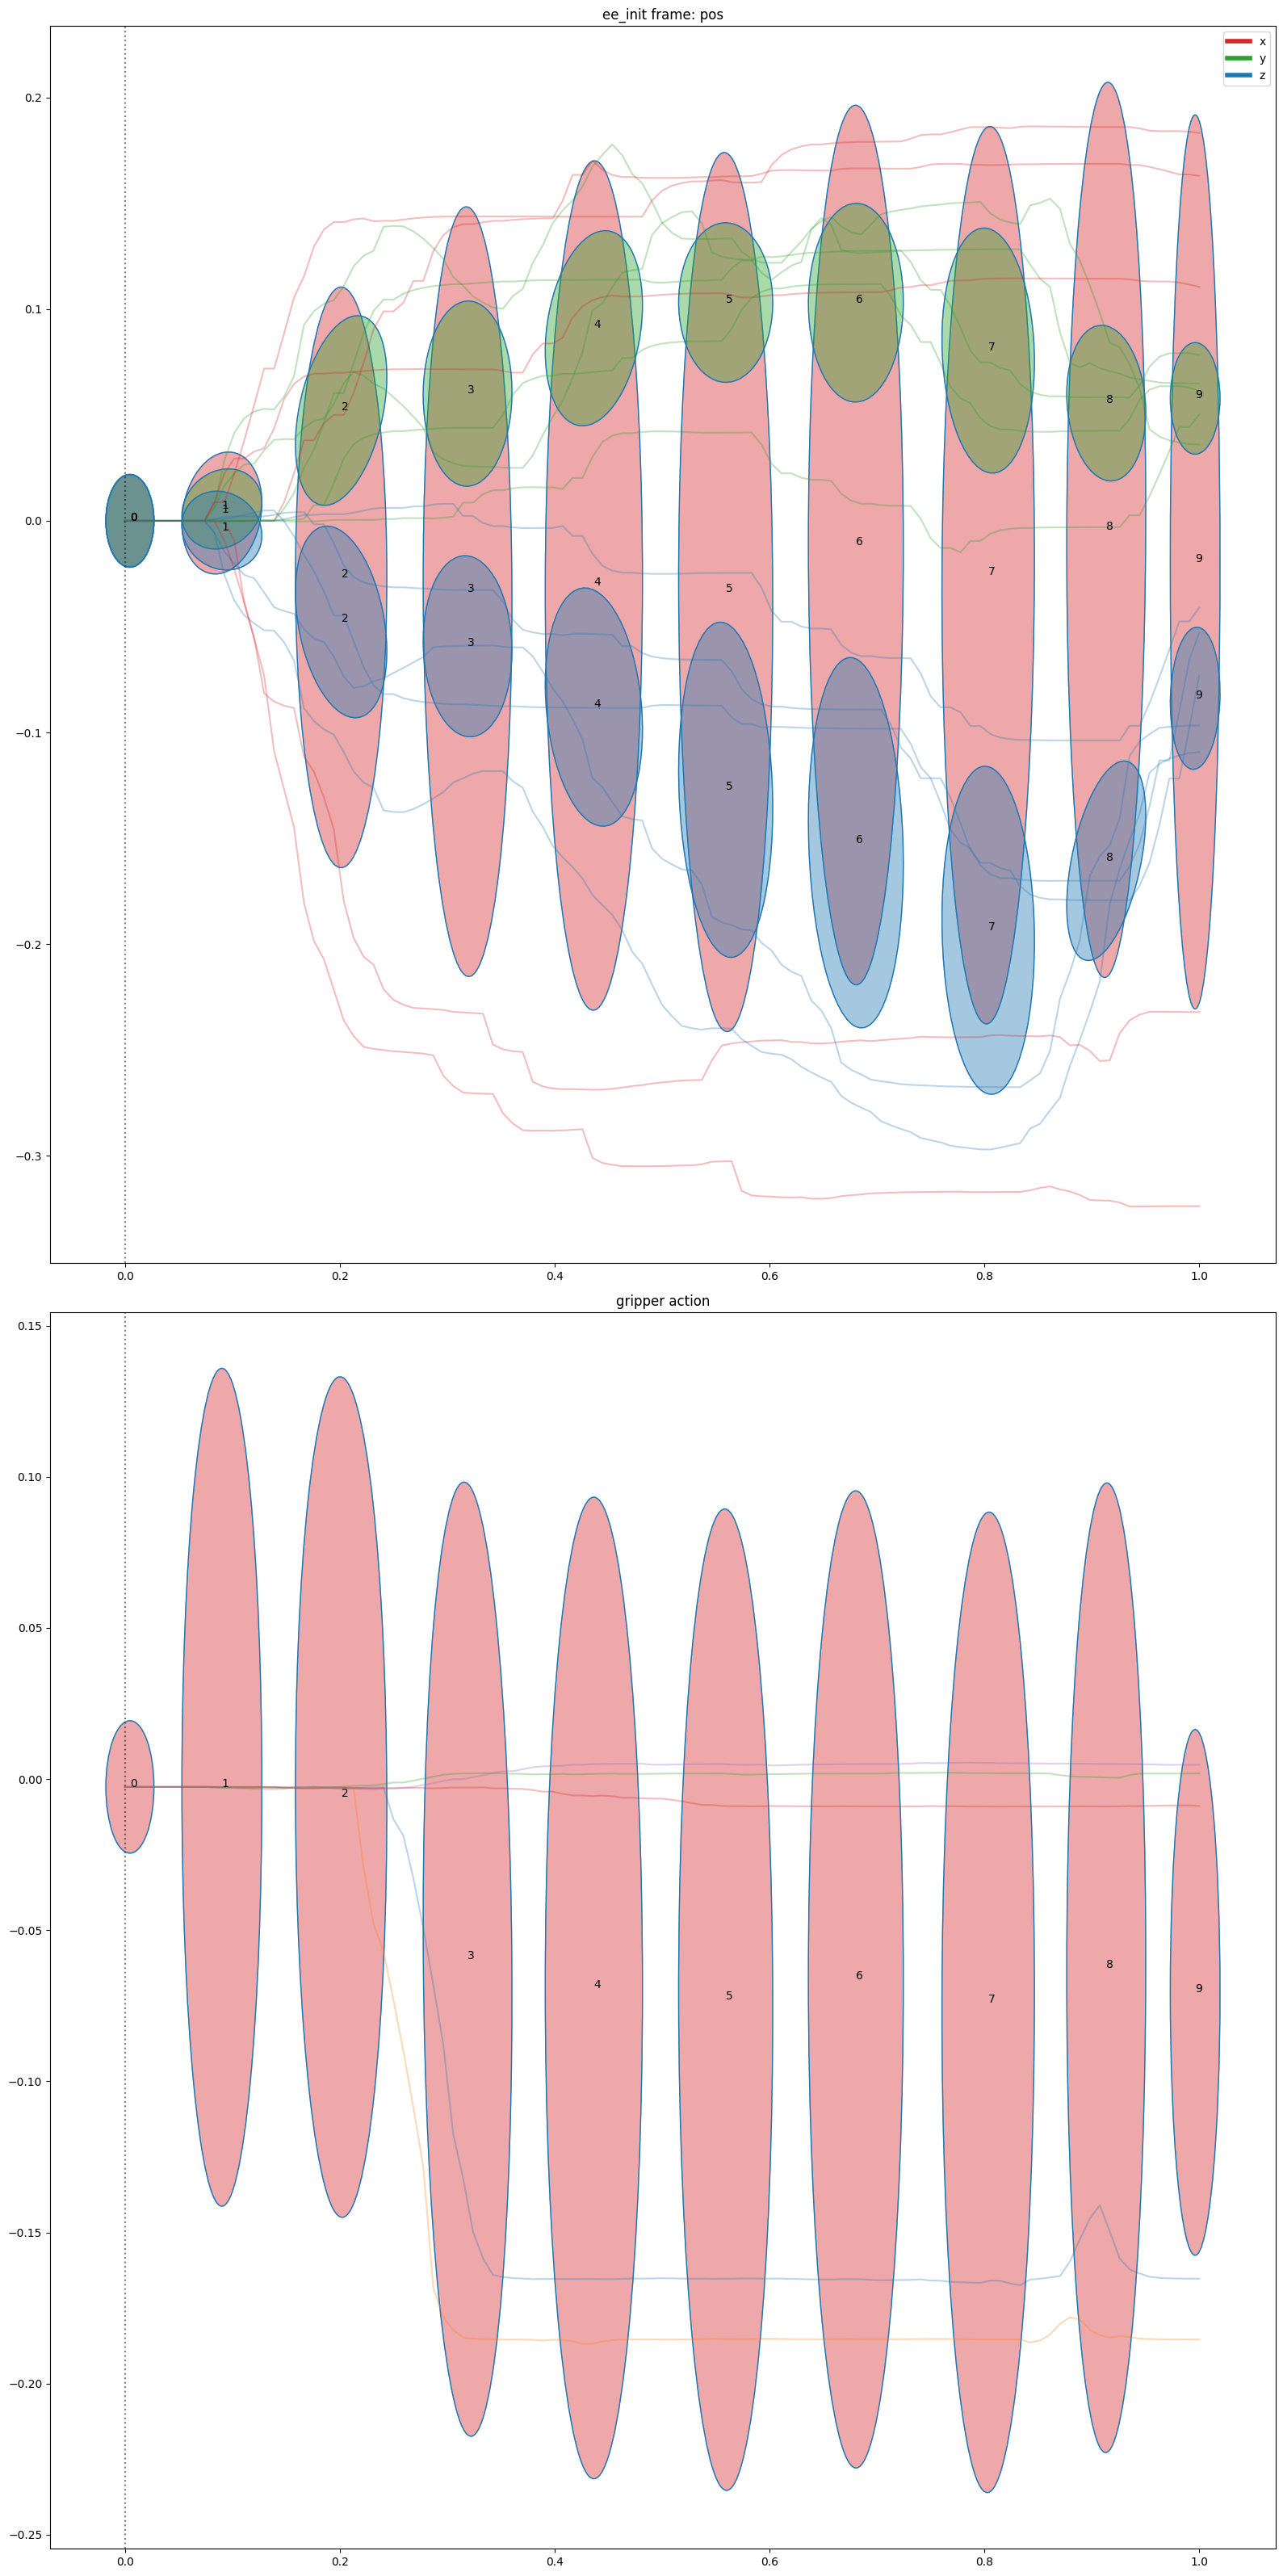

In [42]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

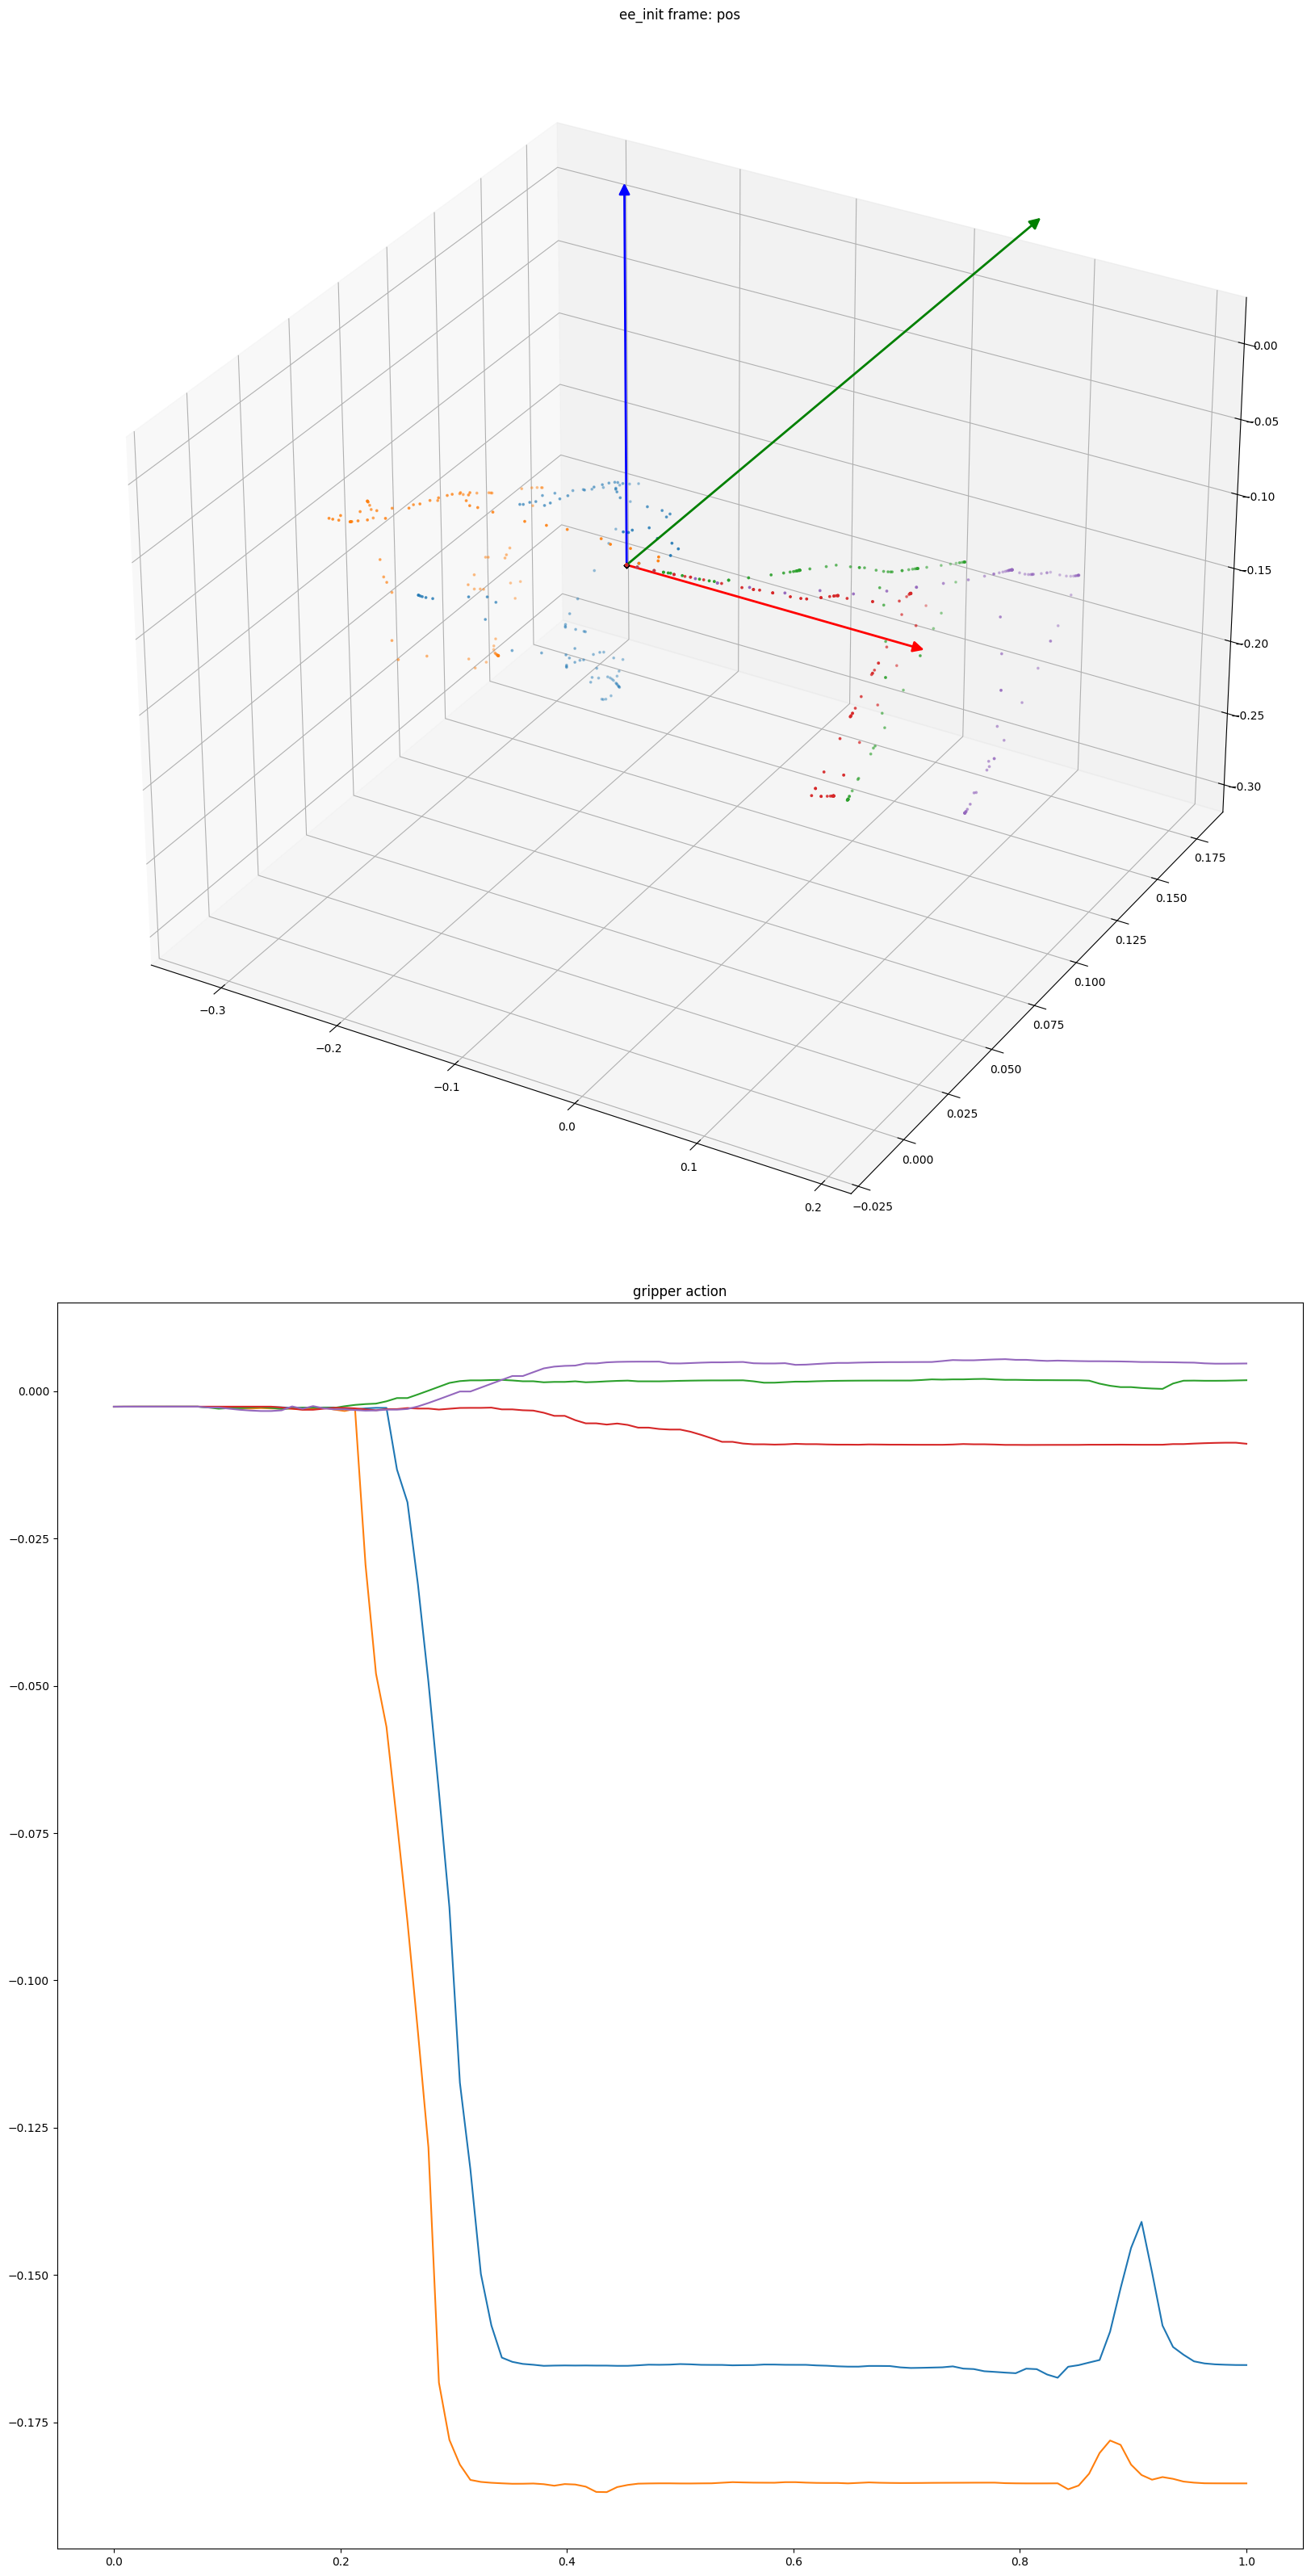

In [43]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

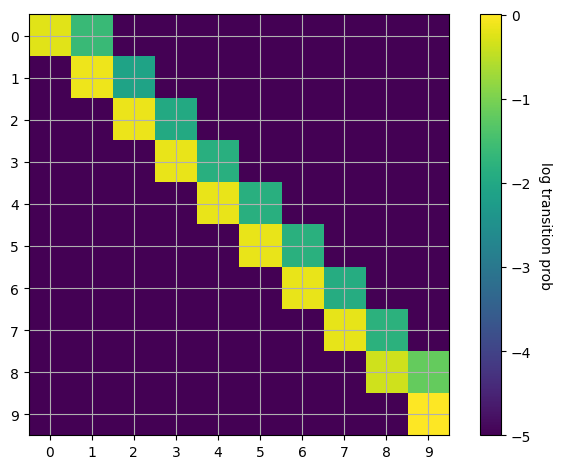

In [44]:
atpgmm.plot_hmm_transition_matrix()

In [45]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-02-18 14:00:00.302 | INFO     |        Saving model:


In [46]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 6, got 4)

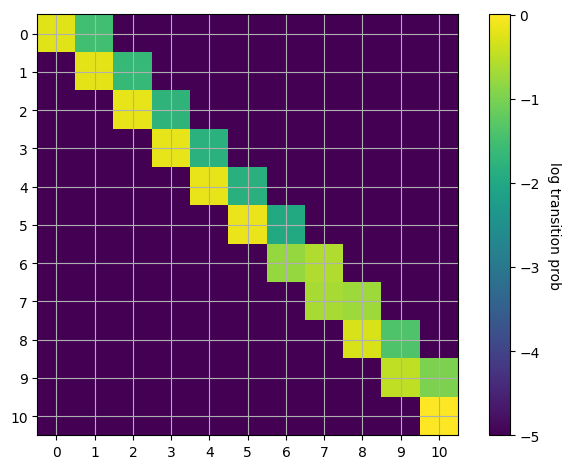

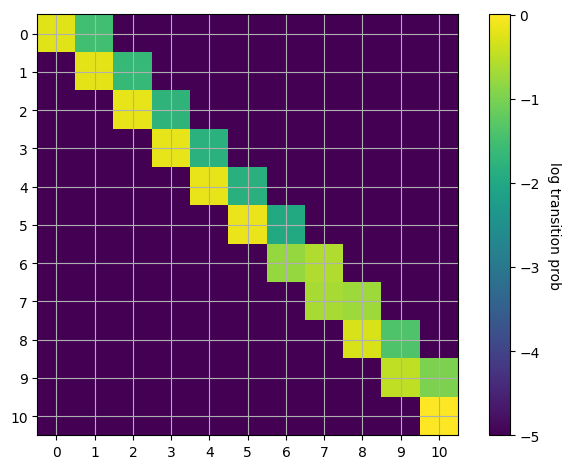

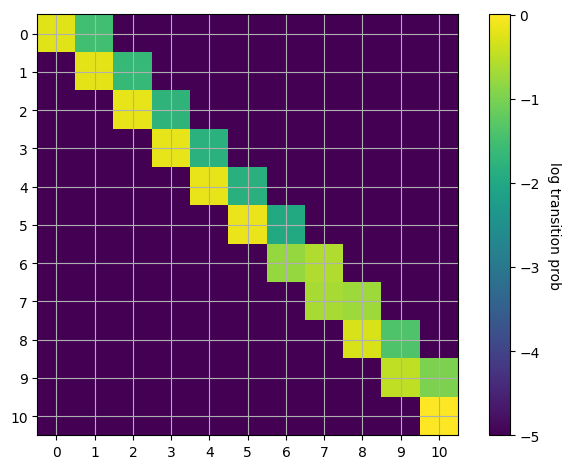

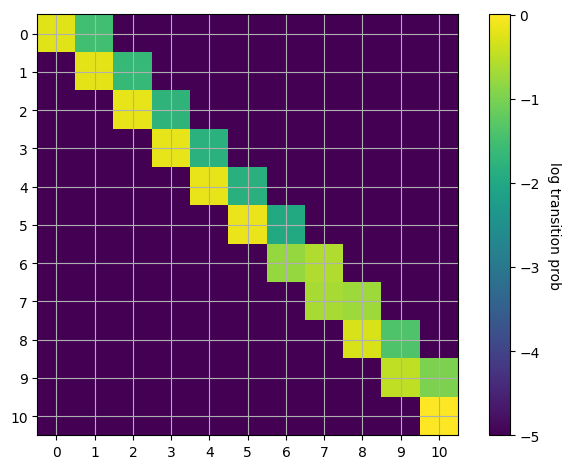

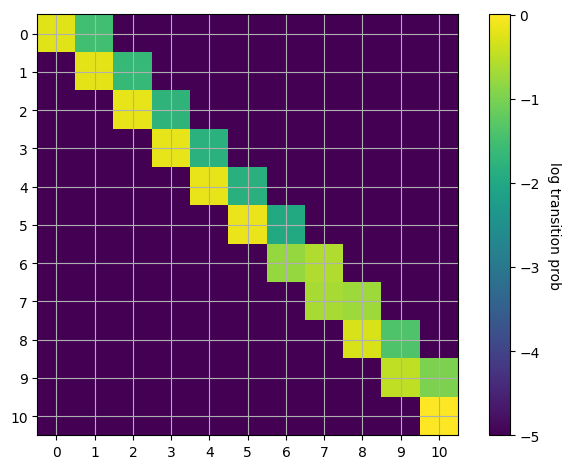

In [18]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-02-09 02:35:54.076 | INFO     |  Taking frame origins from demos.


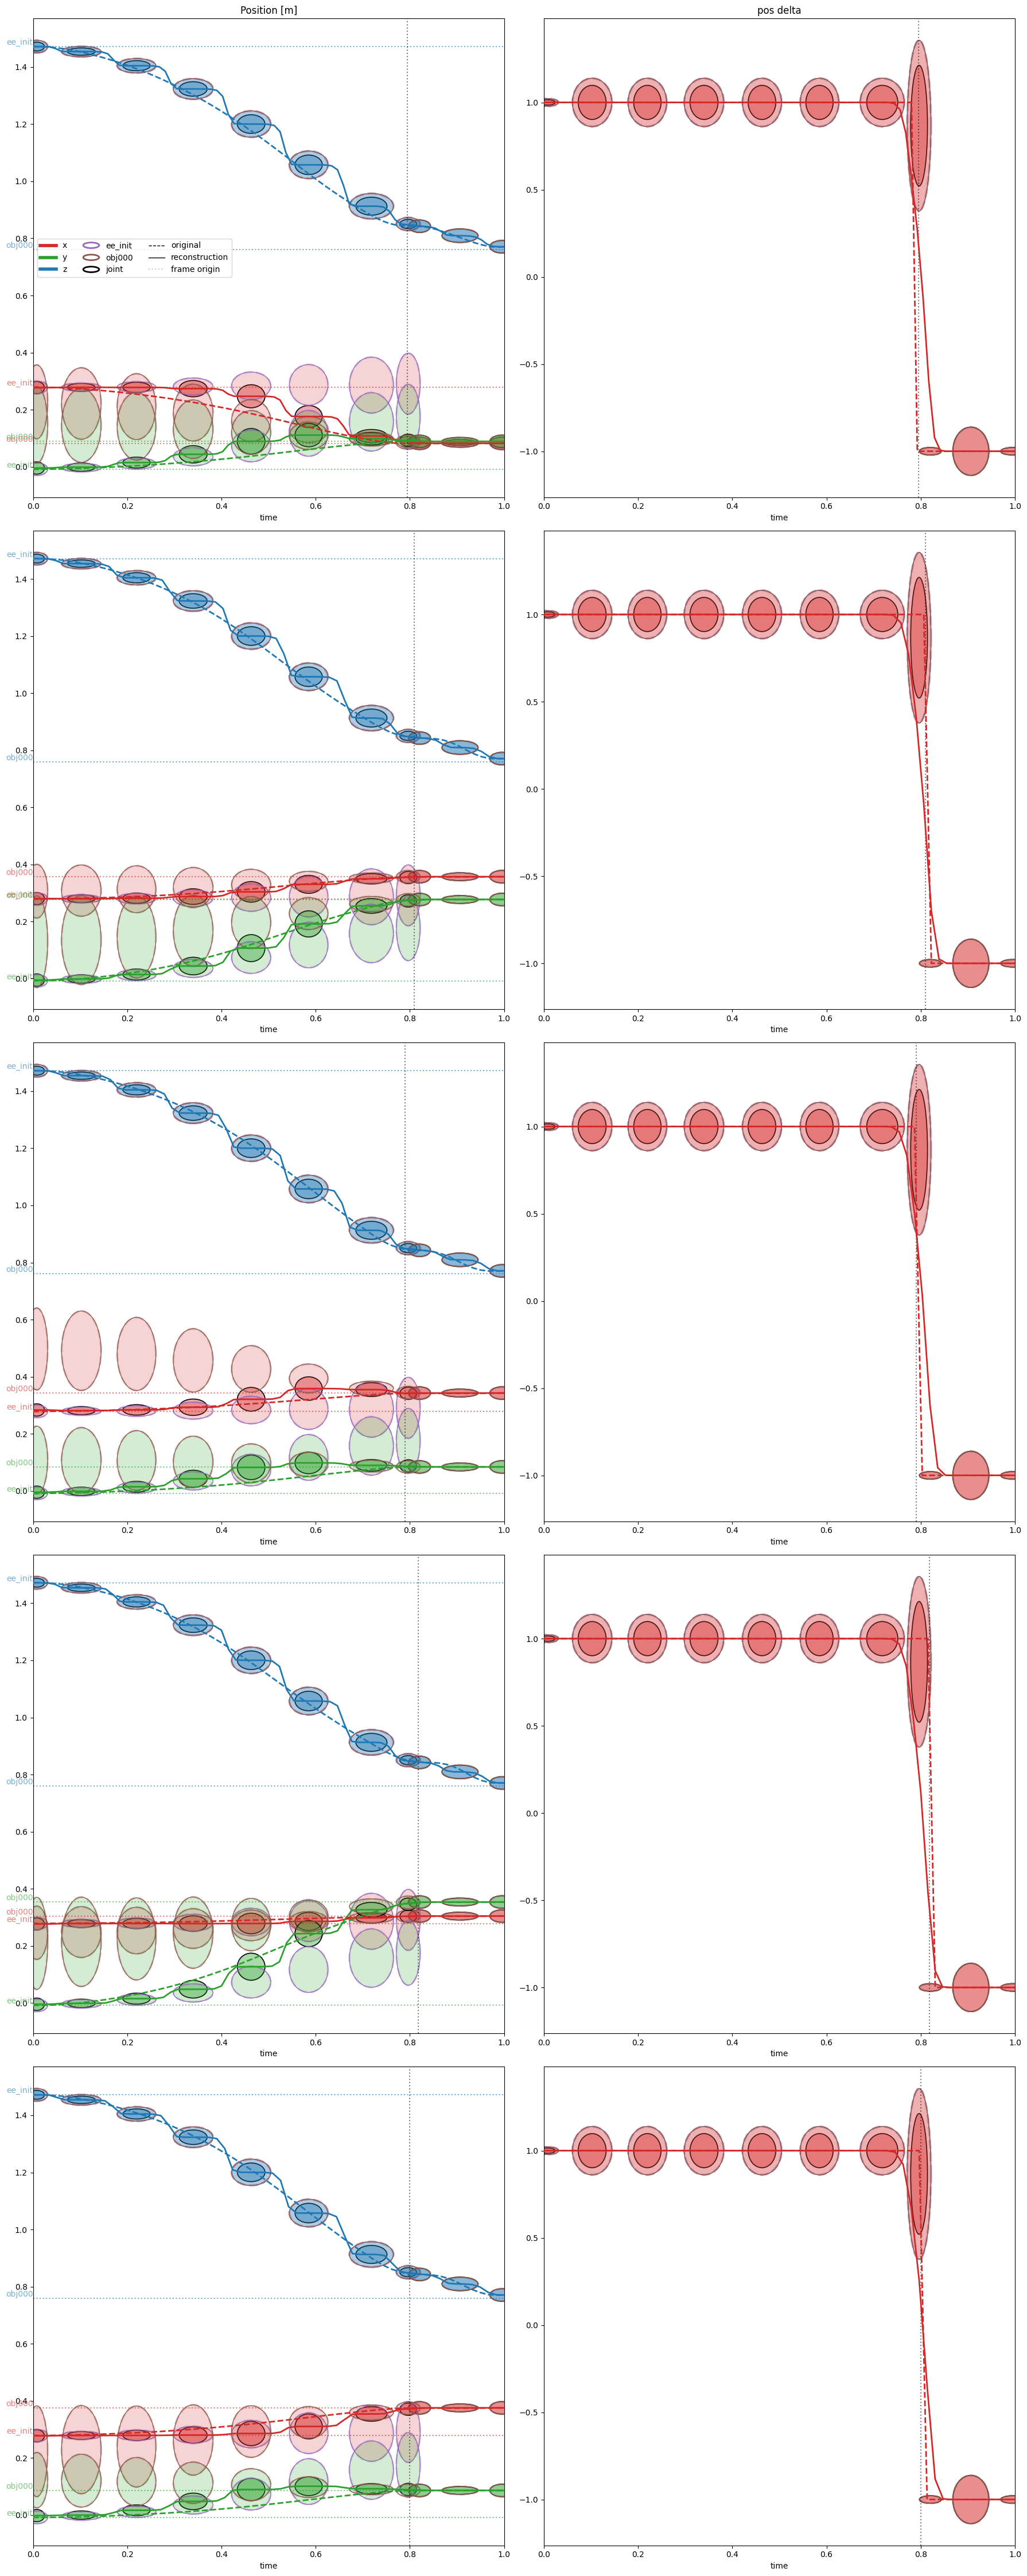

In [19]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2025-02-09 02:36:23.410 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


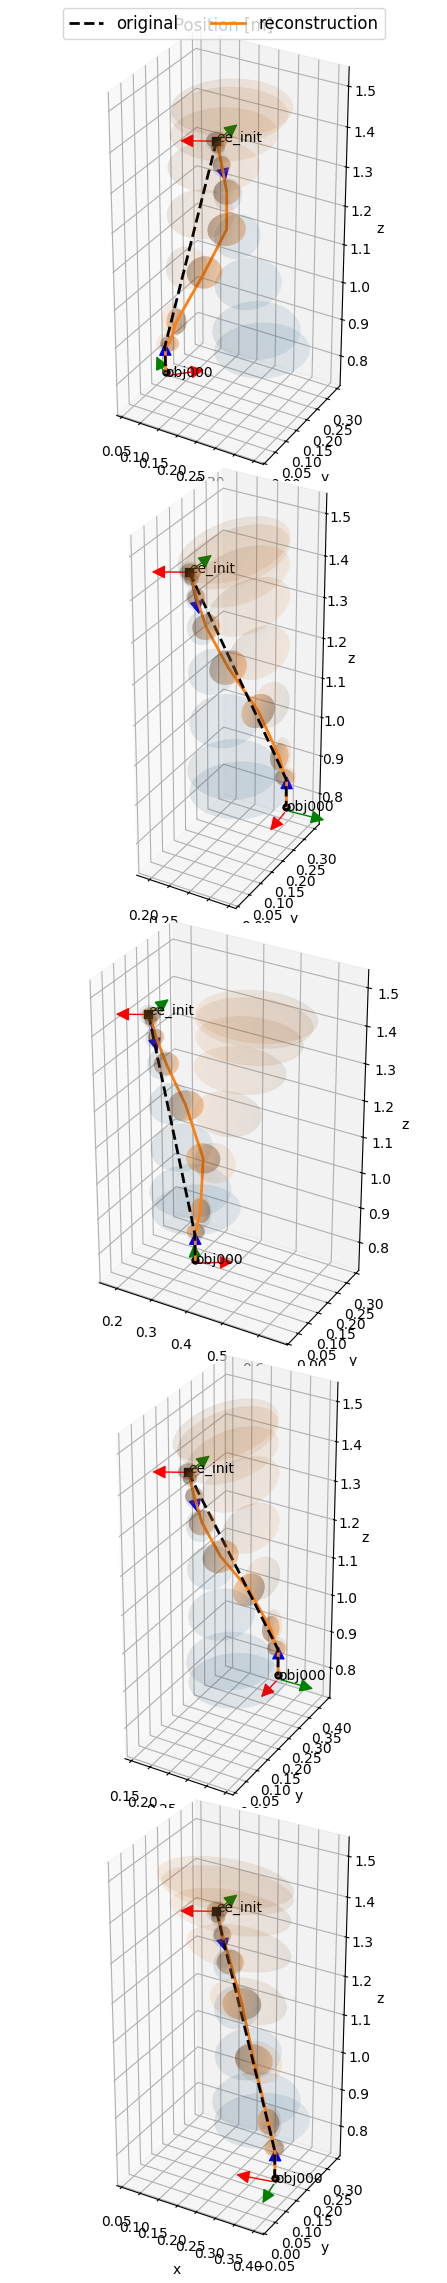

In [20]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
